author: Filip Bucko  
email: xbucko05@vutbr.cz  
institution: Brno University of Technology – Faculty of Information Technology  
date: 18.5.2025  
title: Token Length Distribution Analysis Across Domain Datasets  

# Distribution of Token Lengths Across Multiple Domain Datasets

This notebook analyzes the token-length distributions for four different domain-based datasets:

1. **Raw Domain Names** (DGA, Phishing, Malware)  
2. **RDAP Preprocessed Inputs** (Phishing, Malware)  
3. **DNS Preprocessed Inputs** (Phishing, Malware)  
4. **Geo-IP Preprocessed Inputs** (Phishing, Malware)  

For each dataset we:
- Load domain or input strings from CSV
- Tokenize using the specified transformer tokenizer(s)
- Compute summary statistics (mean, median, tail percentiles)
- Visualize density plots of the sequence lengths  

Use the configuration cells below to adjust model names, dataset paths, and percentile thresholds as needed.


In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


/home/fetagpu/miniconda3/envs/gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Distribution of Token Lengths in Domain Names

In [3]:
# 2. Configuration
MODEL_NAME = "distilbert-base-uncased"          # change once if needed
DATASETS = {
    "DGA"      : "../../datasets/dga/dga_preprocessed.csv",
    "Phishing" : "../../datasets/phishing/phishing_preprocessed.csv",
    "Malware"  : "../../datasets/malware/malware_preprocessed.csv",
}
PERCENTILES = [50, 75, 90, 95, 99, 100]         # median + tails

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [4]:
# 3. Initialize tokenizer (same one you're using in training)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [5]:
# 4. Tokenize all samples and measure their lengths for the malicious domain categories
stats = {}
for name, path in DATASETS.items():
    df = pd.read_csv(path, usecols=["domain_name"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in tqdm(df["domain_name"].astype(str), desc=f"Tokenising {name}", leave=False)
    ]
    lens = np.asarray(lens)

    stats[name] = {
        "mean"   : lens.mean(),
        "median" : np.median(lens),
        **{f"{p}%": np.percentile(lens, p) for p in PERCENTILES[1:]},  # skip 50 (median)
    }

table = (
    pd.DataFrame(stats)
      .reindex(["mean", "median"] + [f"{p}%" for p in PERCENTILES[1:]])
      .round(2)
)

display(table)  # nice HTML table in Jupyter


Tokenising DGA:   0%|          | 0/200000 [00:00<?, ?it/s]

,DGA,Phishing,Malware
mean,12.49,13.13,10.94
median,11.00,11.00,9.00
75%,15.00,15.00,12.00
90%,22.00,20.00,17.00
95%,25.00,28.00,22.00
99%,30.00,51.00,29.00
100%,68.00,68.00,72.00


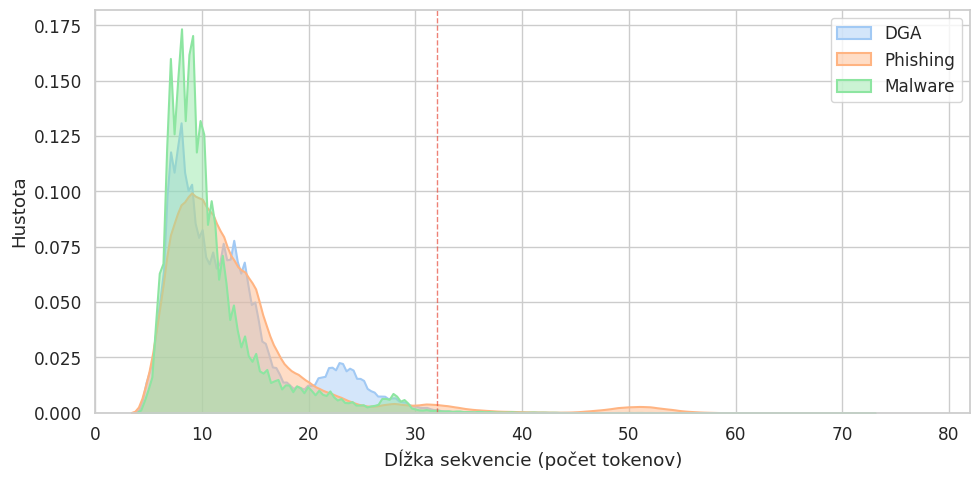

In [ ]:
sns.set_theme(style="whitegrid", font="DejaVu Sans", font_scale=1.1)

plt.figure(figsize=(10, 5))
palette = sns.color_palette("pastel", n_colors=len(DATASETS))

for (name, path), color in zip(DATASETS.items(), palette):
    df = pd.read_csv(path, usecols=["domain_name"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in df["domain_name"].astype(str)
    ]
    sns.kdeplot(
        lens,
        bw_adjust=0.8,
        fill=True,
        alpha=0.45,
        linewidth=1.5,
        label=name,
        color=color,
    )

# optional vertical guides at common truncation lengths
for x, c in zip([32], ["#E74C3C"]):
    plt.axvline(x, linestyle="--", color=c, linewidth=1, alpha=0.7)

max_len = max(table.max()) + 10
plt.xlim(0, max_len)
# plt.title("Token‑length Density Across Datasets", weight="bold")
plt.xlabel("Dĺžka sekvencie (počet tokenov)")
plt.ylabel("Hustota")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

## Distribution of Token Lengths in RDAP

In [2]:
# 1. Configuration
TOKENIZER_MODELS = {
    "Phishing": "distilbert-base-uncased",
    "Malware": "google/electra-base-discriminator",
}
DATASET_PATHS = {
    "Phishing": "../../datasets/phishing/rdap_phishing_preprocessed.csv",
    "Malware": "../../datasets/malware/rdap_malware_preprocessed.csv",
}
PERCENTILES = [50, 75, 90, 95, 99, 100]         # median + tails


In [3]:
# 2. Initialize tokenizers
tokenizers = {
    name: AutoTokenizer.from_pretrained(model_name)
    for name, model_name in TOKENIZER_MODELS.items()
}

In [4]:
# 3. Compute token-length statistics
stats = {}
for name, path in DATASET_PATHS.items():
    tokenizer = tokenizers[name]
    df = pd.read_csv(path, usecols=["input_string"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in tqdm(df["input_string"].astype(str), desc=f"Tokenizing {name}", leave=False)
    ]
    lens = np.array(lens)

    stats[name] = {
        "mean": lens.mean(),
        "median": np.median(lens),
        **{f"{p}%": np.percentile(lens, p) for p in PERCENTILES[1:]},
    }

Tokenizing Phishing:  99%|█████████▉| 253862/255720 [00:57<00:00, 4482.09it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1170 > 512). Running this sequence through the model will result in indexing errors


In [5]:
# 4. Prepare summary table
table = (
    pd.DataFrame(stats)
      .reindex(["mean", "median"] + [f"{p}%" for p in PERCENTILES[1:]])
      .round(2)
)
display(table)  

,Phishing,Malware
mean,192.96,173.38
median,192.00,168.00
75%,215.00,197.00
90%,231.00,217.00
95%,245.00,227.00
99%,273.00,259.00
100%,1170.00,402.00


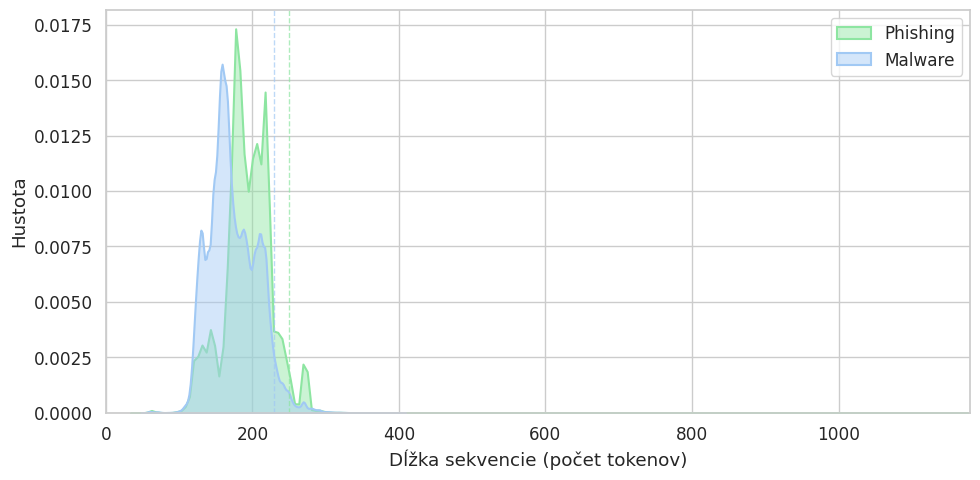

In [6]:
# 5. Plot density distributions
sns.set_theme(style="whitegrid", font="DejaVu Sans", font_scale=1.1)
plt.figure(figsize=(10, 5))
palette_full = sns.color_palette("pastel", 6)
palette = [palette_full[2], palette_full[0]]  # Phishing, Malware
for (name, path), color in zip(DATASET_PATHS.items(), palette):
    tokenizer = tokenizers[name]
    df = pd.read_csv(path, usecols=["input_string"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in df["input_string"].astype(str)
    ]
    sns.kdeplot(
        lens,
        bw_adjust=0.8,
        fill=True,
        alpha=0.45,
        linewidth=1.5,
        label=name,
        color=color,
    )

# # Optional vertical guide at common truncation length
plt.axvline(250, linestyle="--", color=palette[0], linewidth=1, alpha=0.7)
plt.axvline(230, linestyle="--", color=palette[1], linewidth=1, alpha=0.7)

max_len = max(table.max()) + 10
plt.xlim(0, max_len)
plt.xlabel("Dĺžka sekvencie (počet tokenov)")
plt.ylabel("Hustota")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

## Distribution of Token Lengths in DNS

In [7]:
# 1. Configuration
TOKENIZER_MODELS = {
    "Phishing": "distilbert-base-uncased",
    "Malware": "google/electra-base-discriminator",
}
DATASET_PATHS = {
    "Phishing": "../../datasets/phishing/dns_phishing_preprocessed.csv",
    "Malware": "../../datasets/malware/dns_malware_preprocessed.csv",
}
PERCENTILES = [50, 75, 90, 95, 99, 100]         # median + tails


In [8]:
# 2. Initialize tokenizers
tokenizers = {
    name: AutoTokenizer.from_pretrained(model_name)
    for name, model_name in TOKENIZER_MODELS.items()
}

In [9]:
# 3. Compute token-length statistics
stats = {}
for name, path in DATASET_PATHS.items():
    tokenizer = tokenizers[name]
    df = pd.read_csv(path, usecols=["input_string"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in tqdm(df["input_string"].astype(str), desc=f"Tokenizing {name}", leave=False)
    ]
    lens = np.array(lens)

    stats[name] = {
        "mean": lens.mean(),
        "median": np.median(lens),
        **{f"{p}%": np.percentile(lens, p) for p in PERCENTILES[1:]},
    }

In [10]:
# 4. Prepare summary table
table = (
    pd.DataFrame(stats)
      .reindex(["mean", "median"] + [f"{p}%" for p in PERCENTILES[1:]])
      .round(2)
)
display(table)  

,Phishing,Malware
mean,94.69,97.6
median,86.00,92.0
75%,104.00,112.0
90%,128.00,135.0
95%,147.00,150.0
99%,182.00,184.0
100%,324.00,489.0


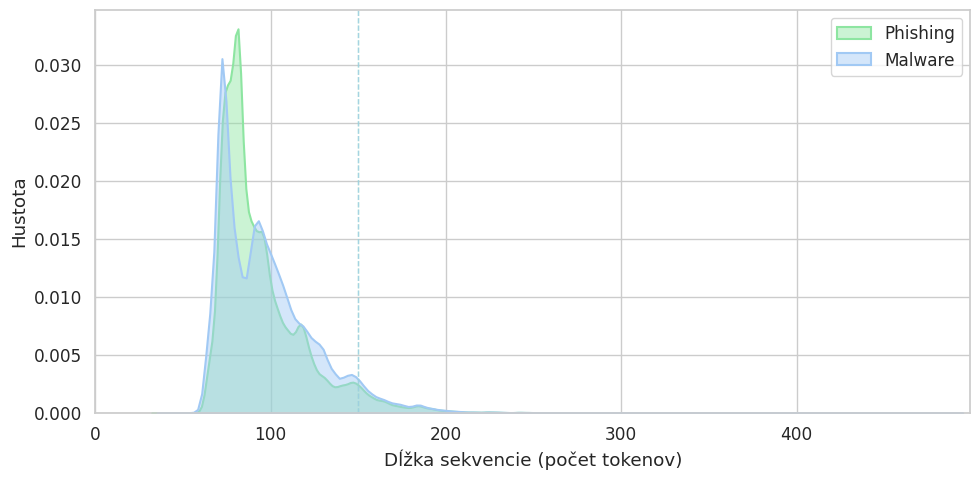

In [11]:
# 5. Plot density distributions
sns.set_theme(style="whitegrid", font="DejaVu Sans", font_scale=1.1)
plt.figure(figsize=(10, 5))
palette_full = sns.color_palette("pastel", 6)
palette = [palette_full[2], palette_full[0]]  # Phishing, Malware
for (name, path), color in zip(DATASET_PATHS.items(), palette):
    tokenizer = tokenizers[name]
    df = pd.read_csv(path, usecols=["input_string"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in df["input_string"].astype(str)
    ]
    sns.kdeplot(
        lens,
        bw_adjust=0.8,
        fill=True,
        alpha=0.45,
        linewidth=1.5,
        label=name,
        color=color,
    )

# # Optional vertical guide at common truncation length
plt.axvline(150, linestyle="--", color=palette[0], linewidth=1, alpha=0.7)
plt.axvline(150, linestyle="--", color=palette[1], linewidth=1, alpha=0.7)

max_len = max(table.max()) + 10
plt.xlim(0, max_len)
plt.xlabel("Dĺžka sekvencie (počet tokenov)")
plt.ylabel("Hustota")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

## Distribution of Token Lengths in GEO

In [12]:
# 1. Configuration
TOKENIZER_MODELS = {
    "Phishing": "distilbert-base-uncased",
    "Malware": "google/electra-base-discriminator",
}
DATASET_PATHS = {
    "Phishing": "../../datasets/phishing/geo_phishing_preprocessed.csv",
    "Malware": "../../datasets/malware/geo_malware_preprocessed.csv",
}
PERCENTILES = [50, 75, 90, 95, 99, 100]         # median + tails


In [13]:
# 2. Initialize tokenizers
tokenizers = {
    name: AutoTokenizer.from_pretrained(model_name)
    for name, model_name in TOKENIZER_MODELS.items()
}

In [14]:
# 3. Compute token-length statistics
stats = {}
for name, path in DATASET_PATHS.items():
    tokenizer = tokenizers[name]
    df = pd.read_csv(path, usecols=["input_string"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in tqdm(df["input_string"].astype(str), desc=f"Tokenizing {name}", leave=False)
    ]
    lens = np.array(lens)

    stats[name] = {
        "mean": lens.mean(),
        "median": np.median(lens),
        **{f"{p}%": np.percentile(lens, p) for p in PERCENTILES[1:]},
    }

In [15]:
# 4. Prepare summary table
table = (
    pd.DataFrame(stats)
      .reindex(["mean", "median"] + [f"{p}%" for p in PERCENTILES[1:]])
      .round(2)
)
display(table)  

,Phishing,Malware
mean,44.28,41.04
median,43.00,40.00
75%,47.00,43.00
90%,52.00,47.00
95%,59.00,50.00
99%,82.00,60.00
100%,184.00,181.00


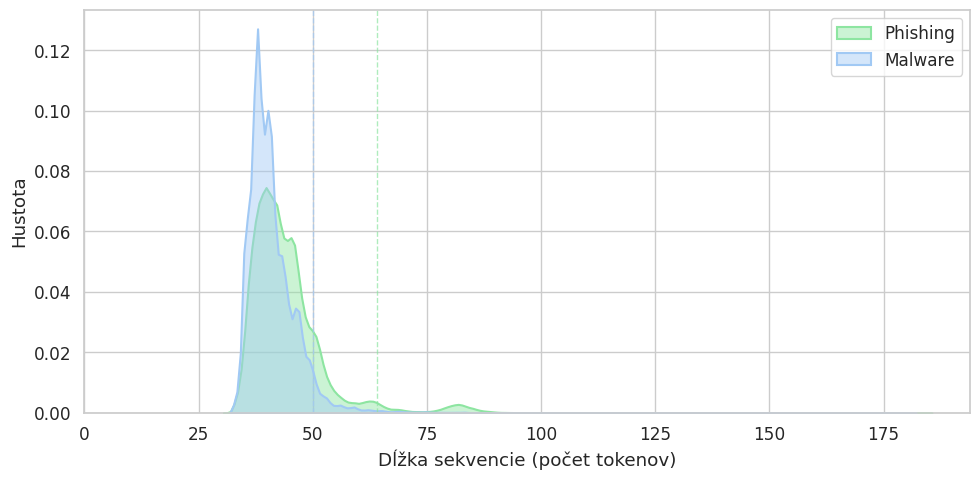

In [16]:
# 5. Plot density distributions
sns.set_theme(style="whitegrid", font="DejaVu Sans", font_scale=1.1)
plt.figure(figsize=(10, 5))
palette_full = sns.color_palette("pastel", 6)
palette = [palette_full[2], palette_full[0]]  # Phishing, Malware
for (name, path), color in zip(DATASET_PATHS.items(), palette):
    tokenizer = tokenizers[name]
    df = pd.read_csv(path, usecols=["input_string"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in df["input_string"].astype(str)
    ]
    sns.kdeplot(
        lens,
        bw_adjust=0.8,
        fill=True,
        alpha=0.45,
        linewidth=1.5,
        label=name,
        color=color,
    )

# # Optional vertical guide at common truncation length
plt.axvline(64, linestyle="--", color=palette[0], linewidth=1, alpha=0.7)
plt.axvline(50, linestyle="--", color=palette[1], linewidth=1, alpha=0.7)

max_len = max(table.max()) + 10
plt.xlim(0, max_len)
plt.xlabel("Dĺžka sekvencie (počet tokenov)")
plt.ylabel("Hustota")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()